In [1]:
# activate ASTRAL/era5, using packages
cd("/Users/deszoeks/Projects/ASTRAL/era5/src") # working directory is src
using Pkg; Pkg.activate("..")    # Project is era5

using NCDatasets
using PyPlot
# using Plots

  Activating project at `~/Projects/ASTRAL/era5`


In [2]:
# read one file

ncfile = filter(x->contains(x,"69e_2023") && endswith(x,".nc"), readdir())[1]
ds = NCDataset(ncfile)

Dataset: xsct_69e_2023.nc
Group: /

Dimensions
   longitude = 1
   latitude = 137
   level = 37
   time = 61

Variables
  longitude   (1)
    Datatype:    Float32 (Float32)
    Dimensions:  longitude
    Attributes:
     units                = degrees_east
     long_name            = longitude

  latitude   (137)
    Datatype:    Float32 (Float32)
    Dimensions:  latitude
    Attributes:
     units                = degrees_north
     long_name            = latitude

  level   (37)
    Datatype:    Int32 (Int32)
    Dimensions:  level
    Attributes:
     units                = millibars
     long_name            = pressure_level

  time   (61)
    Datatype:    Dates.DateTime (Int32)
    Dimensions:  time
    Attributes:
     units                = hours since 1900-01-01 00:00:00.0
     long_name            = time
     calendar             = gregorian

  d   (1 × 137 × 37 × 61)
    Datatype:    Union{Missing, Float64} (Int16)
    Dimensions:  longitude × latitude × level × time
    Att

In [3]:
# try unicodeplots
#= unicodeplots()
contour(ds["vo"][1,:,:,31])
=#
# not great for contours!

# matplotlib()

In [45]:
ds[:vo]

vo (1 × 137 × 37 × 61)
  Datatype:    Union{Missing, Float64} (Int16)
  Dimensions:  longitude × latitude × level × time
  Attributes:
   scale_factor         = 2.7544437512627376e-8
   add_offset           = 0.0005006814256242589
   _FillValue           = -32767
   missing_value        = -32767
   units                = s**-1
   long_name            = Vorticity (relative)
   standard_name        = atmosphere_relative_vorticity


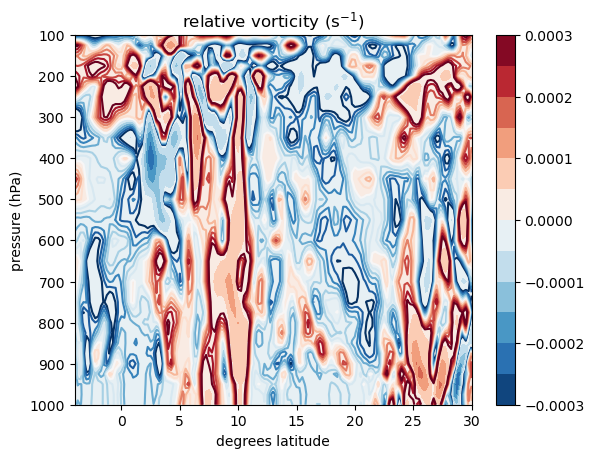

In [69]:
# try pyplot from Plots
#=
pyplot()
contourf(ds[:vo][1,:,:,31+4], 
    cmap = cgrad(:vik25),
    axis = ( font(12, "Times"), )) # doesn't know fonts
=#
# Plots complicates complicated PyPlot grammar

pd = permutedims
clf()
contourf(ds[:latitude][:], ds[:level][:],
    pd(ds[:vo][1,:,:,31+4]), 
    cmap=ColorMap("RdBu_r"), 
    # vmin=-3e-4, vmax=3e-4, 
    levels=1e-4*(-3:0.5:3) )
colorbar()
contour(ds[:latitude][:], ds[:level][:],
    pd(ds[:vo][1,:,:,31+4]), 
    cmap=ColorMap("RdBu_r"), 
    # vmin=-3e-4, vmax=3e-4, 
    levels=1e-5*(-3:0.5:3) )
ylim([1000,100])
xlabel("degrees latitude")
ylabel("pressure (hPa)")
title("relative vorticity (s"*L"^{-1}"*")")
gcf()


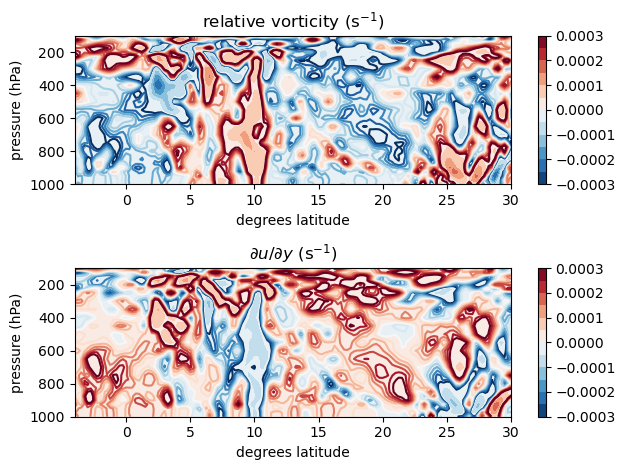

In [78]:
const æ = 6.37e6 # radius of earth

"meridional derivative. ∂y(u) has same size as u"
function ∂y(u, y=ds[:latitude][:])
    # u = ds[:u][1,:,:,:] # eliminate singleton dim
    du = diff(u, dims=1)
    dy = æ * pi/180 * ([0; diff(y,dims=1)] .+ [diff(y,dims=1); 0])
    uy = zeros(size(u))
    uy[1:end-1,:,:] .= du
    uy[2:end,:,:] .+= du
    uy ./ dy
end

dudy = ∂y( ds[:u][1,:,:,:] )
dvdx = ds[:vo][1,:,:,:] .+ dudy

clf()
subplot(2,1,1)
contourf(ds[:latitude][:], ds[:level][:],
    pd(ds[:vo][1,:,:,31+4]), 
    cmap=ColorMap("RdBu_r"), 
    # vmin=-3e-4, vmax=3e-4, 
    levels=1e-4*(-3:0.5:3) )
colorbar()
contour(ds[:latitude][:], ds[:level][:],
    pd(ds[:vo][1,:,:,31+4]), 
    cmap=ColorMap("RdBu_r"), 
    # vmin=-3e-4, vmax=3e-4, 
    levels=1e-5*(-3:0.5:3) )
ylim([1000,100])
xlabel("degrees latitude")
ylabel("pressure (hPa)")
title("relative vorticity (s"*L"^{-1}"*")")

subplot(2,1,2)
contourf( ds[:latitude][:], ds[:level][:], 
    pd(dudy[:,:,31+4]),
   #vmin=-3e-4, vmax=3e-4,
    levels=1e-4.*(-3:0.5:3),
    cmap=ColorMap("RdBu_r"))
colorbar()
contour( ds[:latitude][:], ds[:level][:], 
    pd(dudy[:,:,31+4]),
    #vmin=-3e-4, vmax=3e-4,
    levels=1e-5.*(-3:0.5:3),
    cmap=ColorMap("RdBu_r"))
ylim([1000, 100])
xlabel("degrees latitude")
ylabel("pressure (hPa)")
title(L"\partial u/\partial y"*" (s"*L"^{-1}"*")")
tight_layout()
gcf()

In [87]:
# characteristic frequencies

# buoyancy frequency
const grav = 9.8 
const Rd = 287.0
const Cp = 1005.0
RdoCp = Rd/Cp

let T = ds[:t][1,:,:,:], p = ds[:level][:]
    dlnTdlnp = diff(log.(T),dims=2) ./ diff(pd(log.(p)),dims=2)
    (dlnTdlnp[:,1:end-1,:].+dlnTdlnp[:,2:end,:])
    # X = cat( dlnTdlnp[:,1,:], (dlnTdlnp[:,1:end-1,:].+dlnTdlnp[:,2:end,:])/2, dlnTdlnp[:,end,:]; dims=2)
    # N² = grav^2/(Rd*T) * (RdoCp - X)
end

137×35×61 Array{Float64, 3}:
[:, :, 1] =
 -0.0497507  -0.153372  -0.142557  …  0.392692  0.382275  0.382359
 -0.0518843  -0.15443   -0.148328     0.390918  0.390132  0.375093
 -0.0533809  -0.155619  -0.153555     0.393162  0.377672  0.385879
 -0.0540502  -0.15699   -0.156848     0.400049  0.394866  0.381558
 -0.0542833  -0.158477  -0.157387     0.387044  0.414677  0.381712
 -0.0546491  -0.159938  -0.155384  …  0.389563  0.380531  0.382499
 -0.0553573  -0.161125  -0.151784     0.429684  0.366116  0.346781
 -0.056078   -0.161856  -0.147846     0.455922  0.372094  0.322251
 -0.0560543  -0.161967  -0.14457      0.462447  0.380118  0.333639
 -0.0546541  -0.161322  -0.142501     0.458111  0.378281  0.338101
  ⋮                                ⋱                      
 -0.0814797  -0.220384  -0.140589     0.188322  0.392923  0.5663
 -0.0852403  -0.220108  -0.137755     0.224886  0.411881  0.56495
 -0.088591   -0.219425  -0.135846  …  0.260778  0.429272  0.557243
 -0.0912633  -0.218503  -0.13495